In [1]:
from PIL import Image
import numpy as np
import cupy as cp
from matplotlib import pyplot, cm
from tqdm.notebook import tqdm
from IPython.display import display

In [14]:
def compute_coordinates(res, pitch):
    """Return an array of shape (res) containing the coordinates of a sampling lattice with given pitch."""
    indices = cp.arange(res)
    return (indices - res/2 + 0.5) * pitch

def compute_intervals(res, pitch):
    """Return an array of shape (res+1) containing the boundaries of each sampling cell."""
    indices = cp.arange(res+1)
    return (indices - res/2) * pitch

def ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the coordinates on the retina corresponding to the given coordinates on planes A and B."""
    return (x_a * (1.0 - z_b/z_f) - x_b * (1.0 - z_a/z_f)) * (z_r / (z_a - z_b))

def ra_to_p(x_r, x_a, z_r, z_a, z_f):
    """Return the coordinates on the pupil corresponding to the given coordinates on plane A and on the retina."""
    return (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)

def compute_imaging_tensor(x_r, ivl_a, ivl_b, z_r, z_a, z_b, z_f, pupil_diameter):
    """Return the flatland imaging tensor."""
    # Project intervals to the pupil
    ivl_a_at_p = ra_to_p(x_r, ivl_a, z_r, z_a, z_f)
    ivl_b_at_p = ra_to_p(x_r, ivl_b, z_r, z_b, z_f)
    # Bounds imposed by the pupil aperture
    lower_bound = -pupil_diameter/2
    upper_bound =  pupil_diameter/2
    # Restrict plane A intervals to the pupil aperture
    ivl_pa = cp.clip(ivl_a_at_p, lower_bound, upper_bound)
    # Bounds imposed by the pupil aperture and plane A intervals together
    lower_bound = cp.minimum(ivl_pa[..., :-1, :], ivl_pa[..., 1:, :])
    upper_bound = cp.maximum(ivl_pa[..., :-1, :], ivl_pa[..., 1:, :])
    # Restrict plane B intervals to the pupil aperture and plane A intervals
    ivl_pab = cp.clip(ivl_b_at_p, lower_bound, upper_bound)
    # Bounds imposed by the pupil aperture, plane A intervals and plane B intervals together
    lower_bound = cp.minimum(ivl_pab[..., :-1], ivl_pab[..., 1:])
    upper_bound = cp.maximum(ivl_pab[..., :-1], ivl_pab[..., 1:])
    # Return the lengths of the intervals normalized by the pupil diameter
    return cp.subtract(upper_bound, lower_bound) / pupil_diameter

def apply_imaging_tensor(img_tsr, signal_ab):
    """Return the image formed by the given imaging tensor over the given light field."""
    return cp.sum(img_tsr * signal_ab, axis=(-2, -1))

def convolution_matrix(x_in, x_out, kernel):
    """Return a convolution matrix with given kernel."""
    return kernel(x_out[..., np.newaxis] - x_in)

def cosine_signal(x, frequency, phase=0.0):
    """Sample a cosine with given frequency and phase at given sampling coordinates."""
    return cp.cos((x * frequency + phase) * 2 * np.pi)/2 + 0.5

def sample_light_field(x_a, x_b, z_r, z_a, z_b, z_f, frequency):
    """Return the sampled light field signal over planes A and B with given frequency at the retina."""
    x_r_over_ab = ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f)
    return cosine_signal(x_r_over_ab, frequency)

def decimate_light_field(signal_ab, factor):
    """Return the light field decimated by given factor."""
    return signal_ab[factor//2::factor, factor//2::factor]

def filter_light_field(signal_ab, filter_kernel):
    """Return the light field filtered on the frequency domain by a given kernel."""
    return cp.real(cp.fft.ifft2(cp.fft.fft2(signal_ab) * filter_kernel))

def create_filter(omega_a, omega_b, z_r, z_a, z_b, z_near, z_far, xi_r, xi_p=0.0):
    """Return an hourglass-shaped filter defined from near and far focus distance and maximum frequency at the retina."""
    mask_near = (z_near * (omega_a + omega_b) - z_a * omega_a - z_b * omega_b) < 0
    mask_far = (z_far * (omega_a + omega_b) - z_a * omega_a - z_b * omega_b) > 0
    mask_depth = cp.logical_not(cp.logical_xor(mask_near, mask_far))
    mask_p_near = cp.abs((1 - z_a/z_near) * omega_a + (1 - z_b/z_near) * omega_b) < xi_p
    mask_p_far = cp.abs((1 - z_a/z_far) * omega_a + (1 - z_b/z_far) * omega_b) < xi_p
    mask_p = cp.logical_or(mask_p_near, mask_p_far)
    mask_r = cp.abs(z_a * omega_a + z_b * omega_b) < abs(z_r) * xi_r
    return cp.logical_and(mask_r, cp.logical_or(mask_depth, mask_p)) * 1.0

def display_image(values, color_map=None):
    """Display an array of values as an image using a color map."""
    color_values = cm.get_cmap(color_map)(values)
    uint8_values = (color_values * 255).astype(np.uint8)
    display(Image.fromarray(uint8_values).transpose(Image.ROTATE_90))

In [3]:
z_r = -17.0
z_a = 10.0
z_b = 30.0
z_near = 50.0
z_far = cp.inf

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + pupil_diameter
size_b = size_r * z_b / abs(z_r) + pupil_diameter

res_r = 512
res_a = 64
res_b = 64
supersampling = 5 # This value must be an odd number!

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

xi_r = 0.5 / pitch_r
xi_a = 0.5 / pitch_a
xi_b = 0.5 / pitch_b

In [4]:
x_r = compute_coordinates(res_r, pitch_r)
omega_r =  cp.fft.fftfreq(res_r, pitch_r)

x_a = compute_coordinates(res_a, pitch_a)[    ::    , np.newaxis]
omega_a =  cp.fft.fftfreq(res_a, pitch_a)[    ::    , np.newaxis]

x_b = compute_coordinates(res_b, pitch_b)[np.newaxis,     ::    ]
omega_b =  cp.fft.fftfreq(res_b, pitch_b)[np.newaxis,     ::    ]

x_a_sup = compute_coordinates(res_a*supersampling, pitch_a/supersampling)[    ::    , np.newaxis]
omega_a_sup =  cp.fft.fftfreq(res_a*supersampling, pitch_a/supersampling)[    ::    , np.newaxis]

x_b_sup = compute_coordinates(res_b*supersampling, pitch_b/supersampling)[np.newaxis,     ::    ]
omega_b_sup =  cp.fft.fftfreq(res_b*supersampling, pitch_b/supersampling)[np.newaxis,     ::    ]

ivl_a = compute_intervals(res_a, pitch_a)[    ::    , np.newaxis]
ivl_b = compute_intervals(res_b, pitch_b)[np.newaxis,     ::    ]

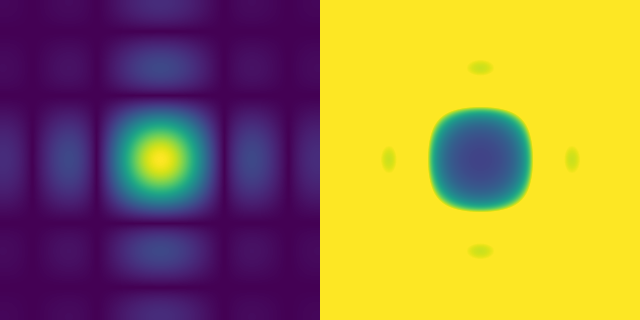

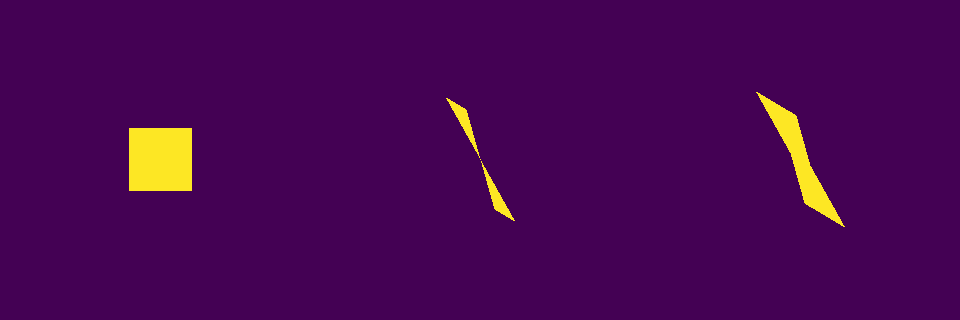

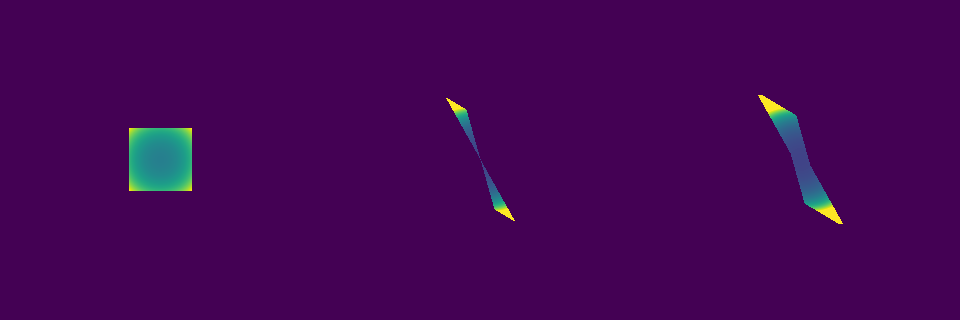

In [5]:
sinc_filter = cp.sinc(omega_a_sup * pitch_a) * cp.sinc(omega_b_sup * pitch_b)
unsinc_filter = cp.clip(1.0 / sinc_filter, -5.0, 5.0)

display_image(cp.vstack((cp.fft.fftshift(cp.abs(sinc_filter)),
                         cp.fft.fftshift(cp.abs(unsinc_filter)) / cp.amax(unsinc_filter))).get())

box_filter = cp.logical_and(cp.abs(omega_a_sup) < xi_a, cp.abs(omega_b_sup) < xi_b) * 1.0
thin_hourglass_filter = create_filter(omega_a_sup, omega_b_sup, z_r, z_a, z_b, z_near, z_far, 5.0)
thick_hourglass_filter = create_filter(omega_a_sup, omega_b_sup, z_r, z_a, z_b, z_near, z_far, 5.0, 0.8)

display_image(cp.vstack((cp.fft.fftshift(box_filter),
                         cp.fft.fftshift(thin_hourglass_filter),
                         cp.fft.fftshift(thick_hourglass_filter))).get())

unsinc_box_filter = box_filter * unsinc_filter
unsinc_thin_hourglass_filter = thin_hourglass_filter * unsinc_filter
unsinc_thick_hourglass_filter = thick_hourglass_filter * unsinc_filter

display_image(cp.vstack((cp.fft.fftshift(unsinc_box_filter) / cp.amax(unsinc_box_filter),
                         cp.fft.fftshift(unsinc_thin_hourglass_filter) / cp.amax(unsinc_thin_hourglass_filter),
                         cp.fft.fftshift(unsinc_thick_hourglass_filter) / cp.amax(unsinc_thick_hourglass_filter))).get())

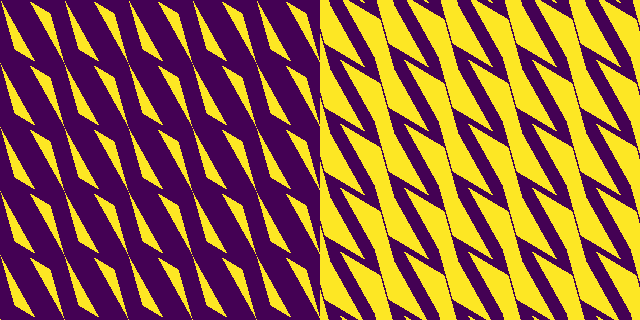

In [6]:
thin_spectrum = cp.abs(cp.fft.fft2(decimate_light_field(cp.fft.ifft2(thin_hourglass_filter), supersampling)))
thick_spectrum = cp.abs(cp.fft.fft2(decimate_light_field(cp.fft.ifft2(thick_hourglass_filter), supersampling)))

display_image(cp.vstack((cp.tile(thin_spectrum, (5, 5)),
                         cp.tile(thick_spectrum, (5, 5)))).get())

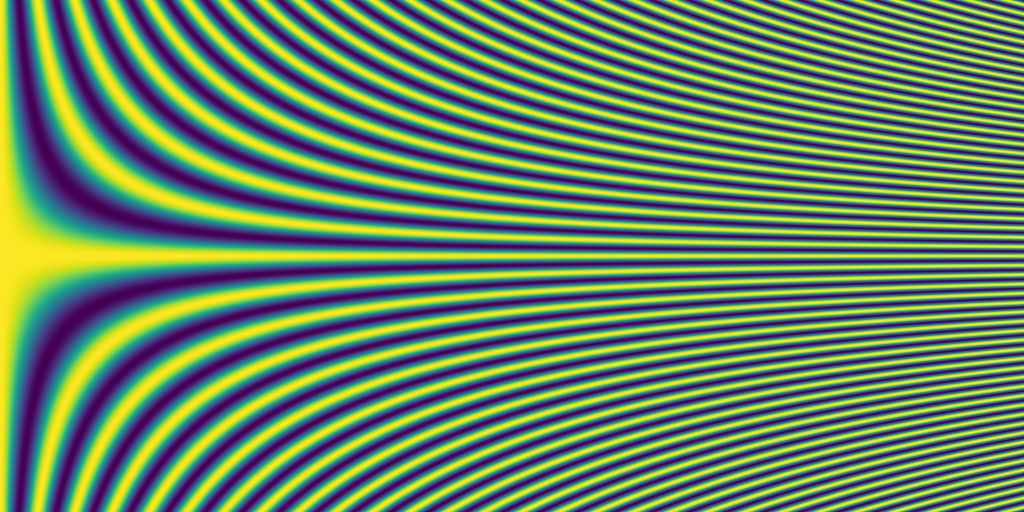

In [7]:
ground_truth = np.zeros((1024, res_r))

for idx, frequency in enumerate(np.linspace(0.0, 10.0, 1024)):
    ground_truth[idx] = cosine_signal(x_r, frequency).get()

display_image(ground_truth)

In [8]:
def single_test(img_tsr, z_f, filter_kernel):
    result = np.zeros((1024, res_r))
    for idx, frequency in enumerate(np.linspace(0.0, 10.0, 1024)):
        signal_ab_sup = sample_light_field(x_a_sup, x_b_sup, z_r, z_a, z_b, z_f, frequency)
        signal_ab_sup_filtered = filter_light_field(signal_ab_sup, filter_kernel)
        signal_ab = decimate_light_field(signal_ab_sup_filtered, supersampling)
        result[idx] = apply_imaging_tensor(img_tsr, signal_ab).get()
    return result

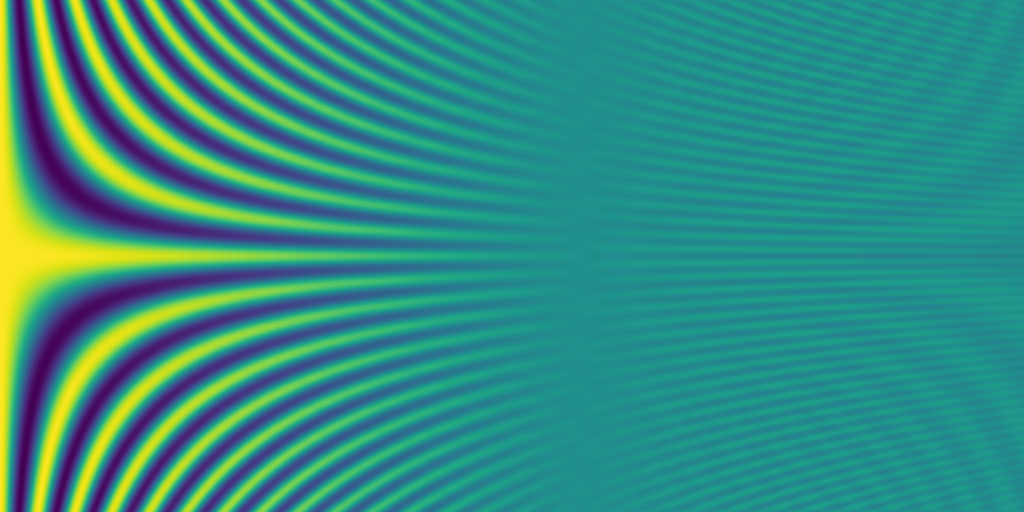

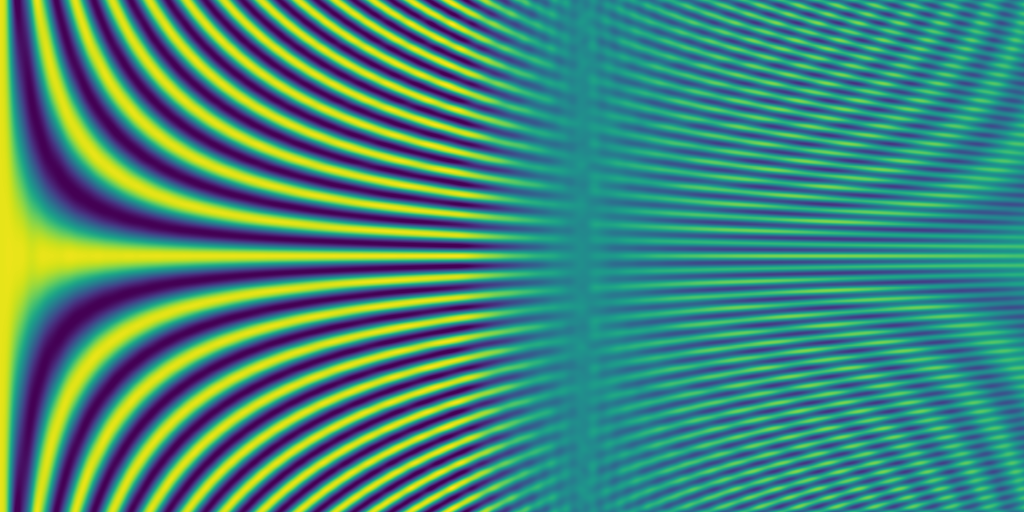

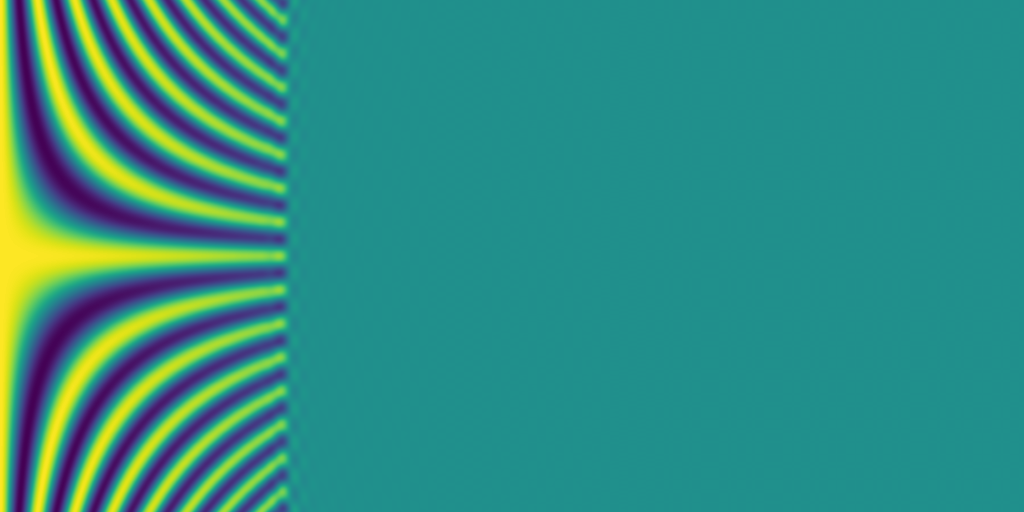

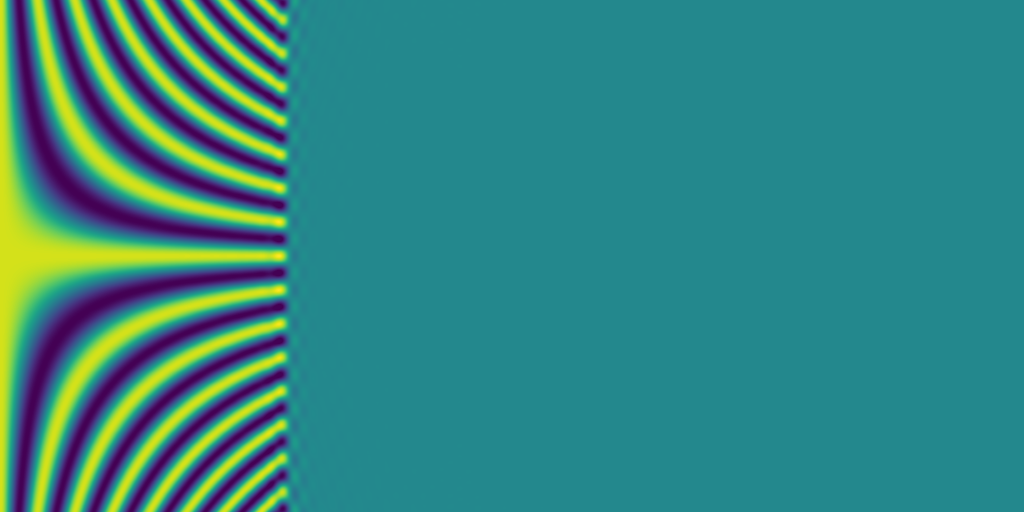

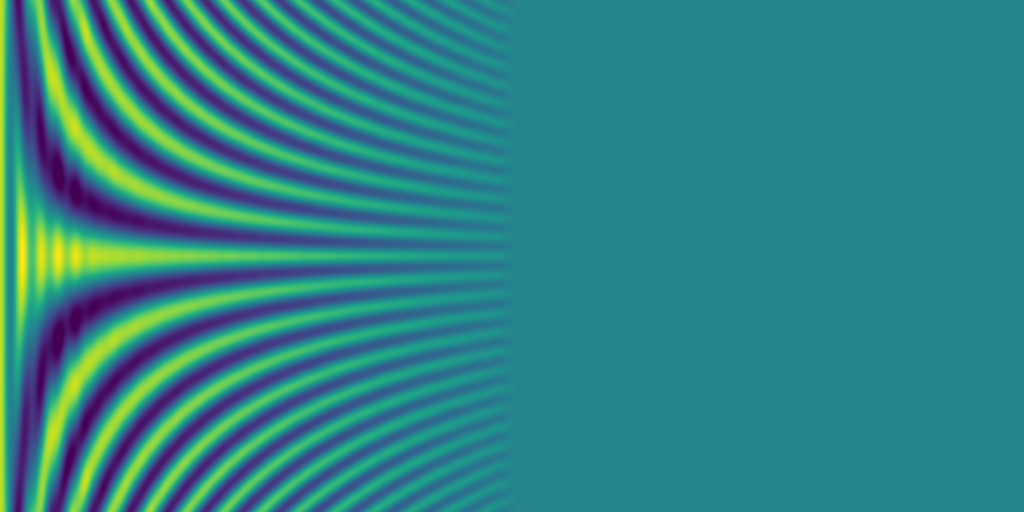

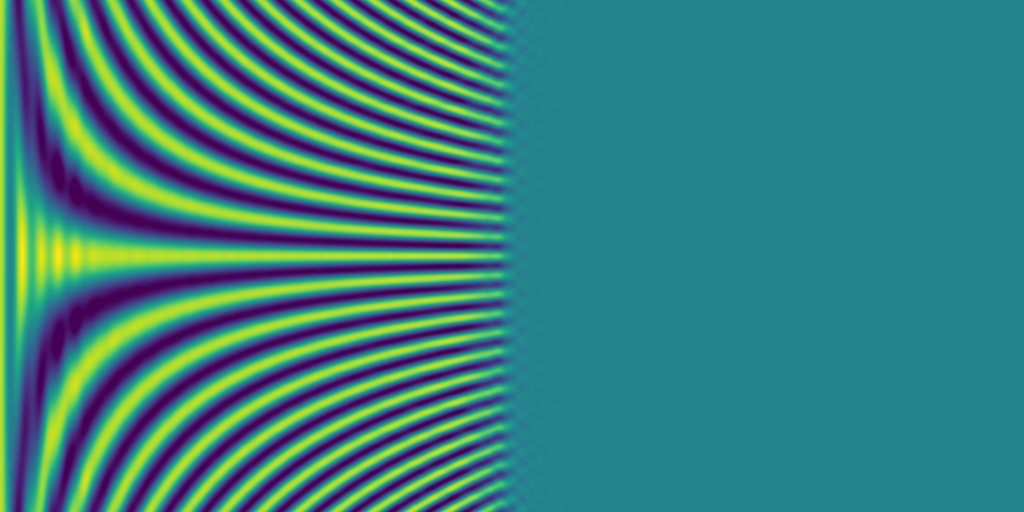

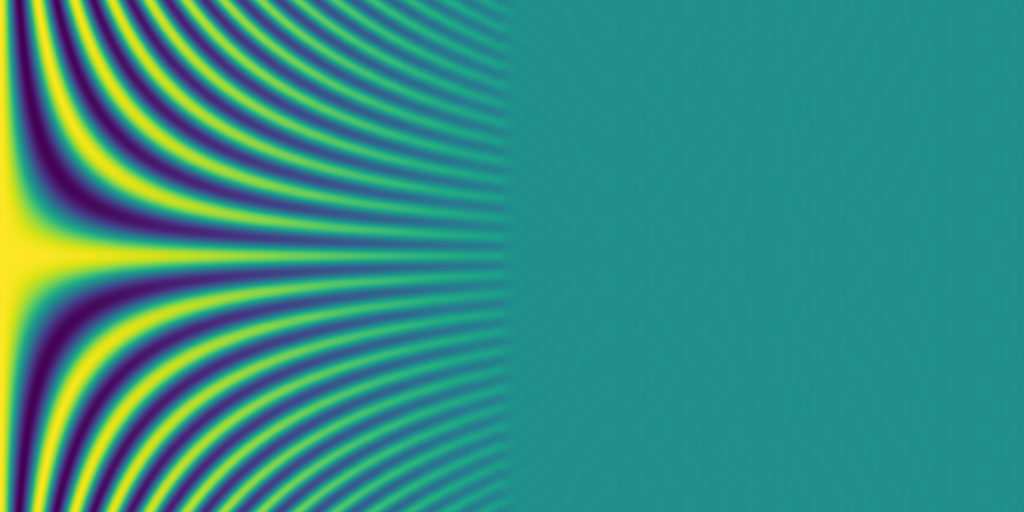

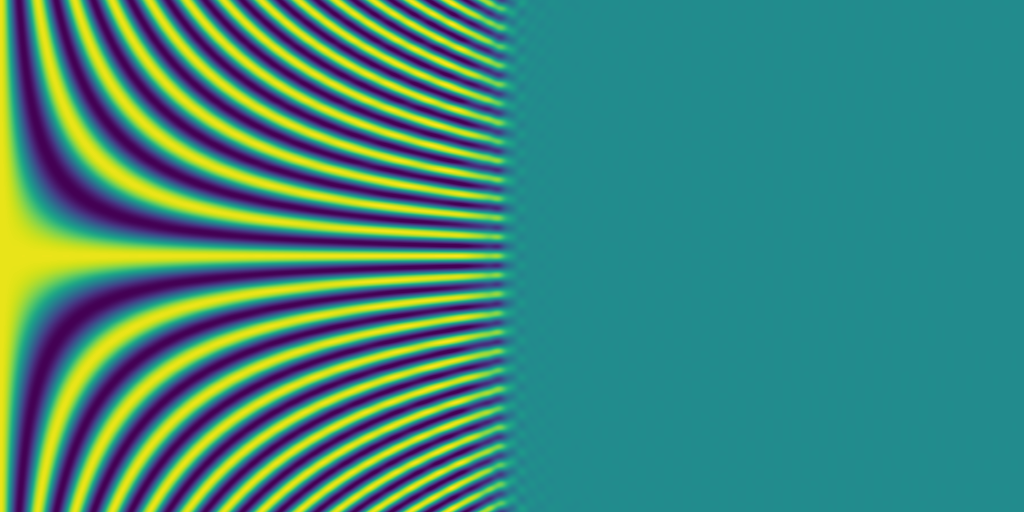

In [9]:
z_f = 100.0
img_tsr = compute_imaging_tensor(x_r[..., np.newaxis, np.newaxis], ivl_a, ivl_b, z_r, z_a, z_b, z_f, pupil_diameter)

display_image(single_test(img_tsr, z_f, 1.0))
display_image(single_test(img_tsr, z_f, unsinc_filter))
display_image(single_test(img_tsr, z_f, box_filter))
display_image(single_test(img_tsr, z_f, unsinc_box_filter))
display_image(single_test(img_tsr, z_f, thin_hourglass_filter))
display_image(single_test(img_tsr, z_f, unsinc_thin_hourglass_filter))
display_image(single_test(img_tsr, z_f, thick_hourglass_filter))
display_image(single_test(img_tsr, z_f, unsinc_thick_hourglass_filter))

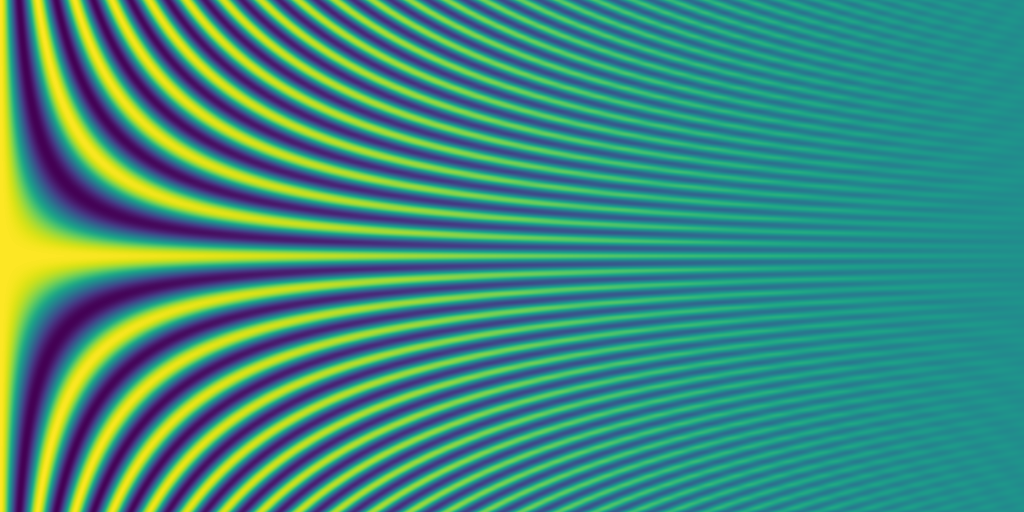

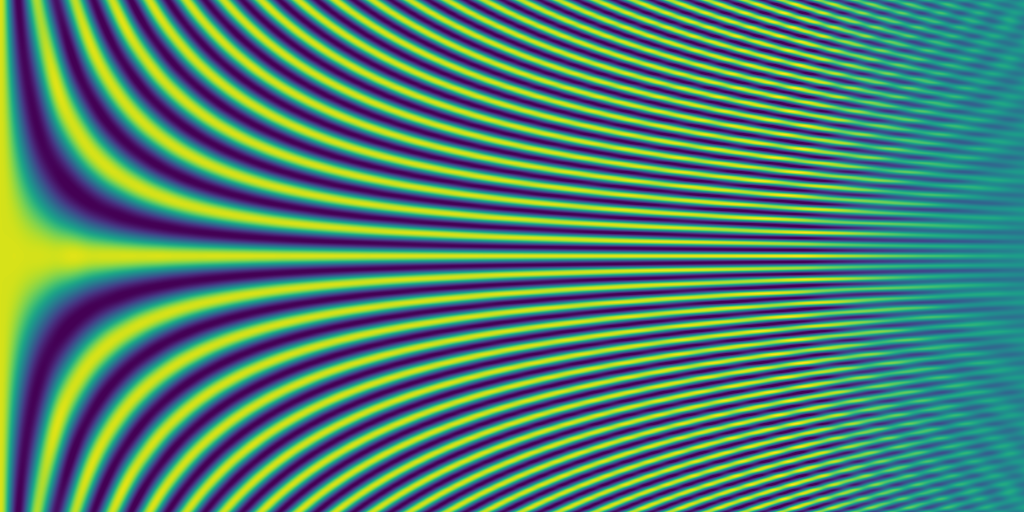

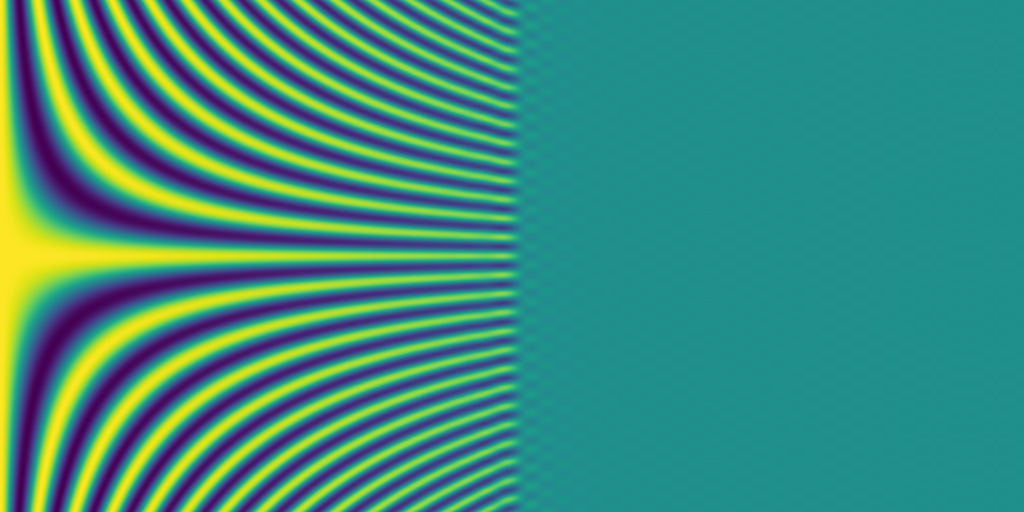

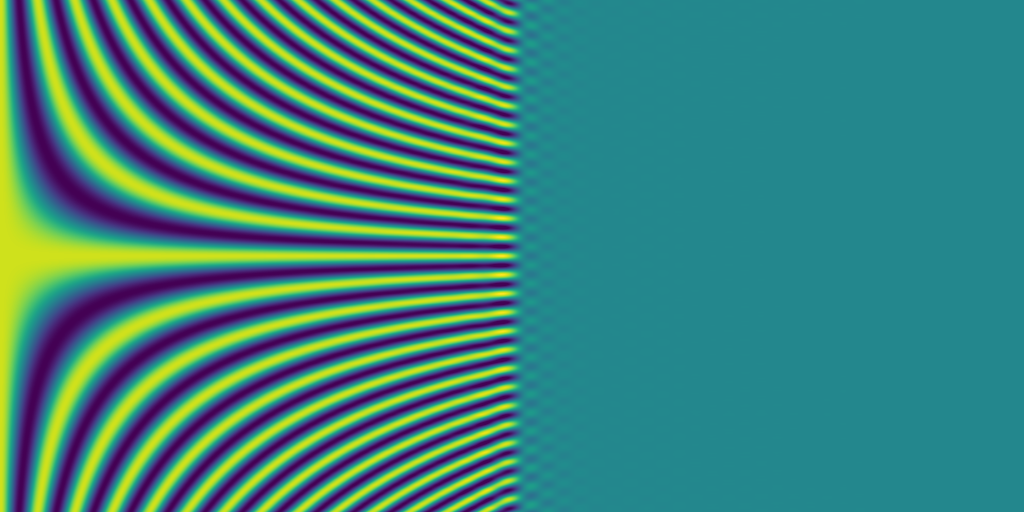

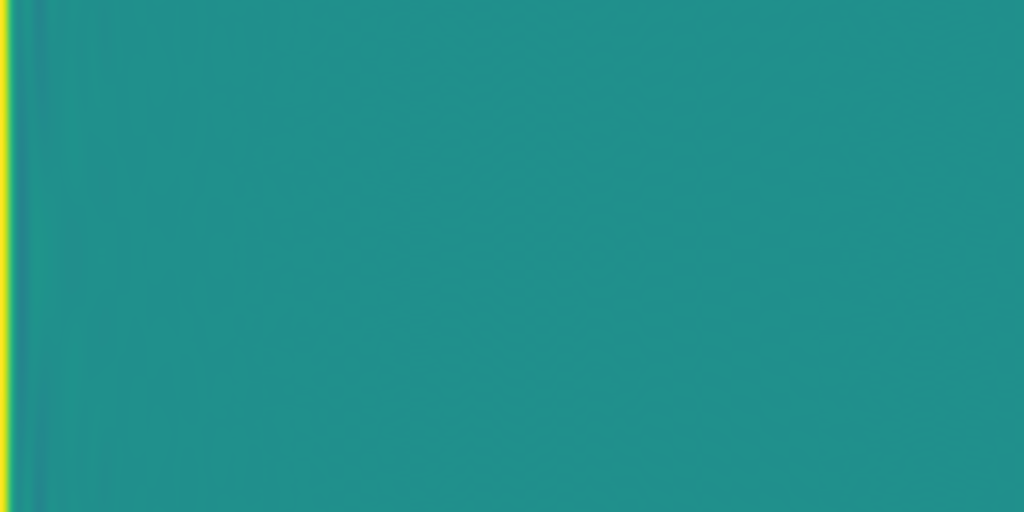

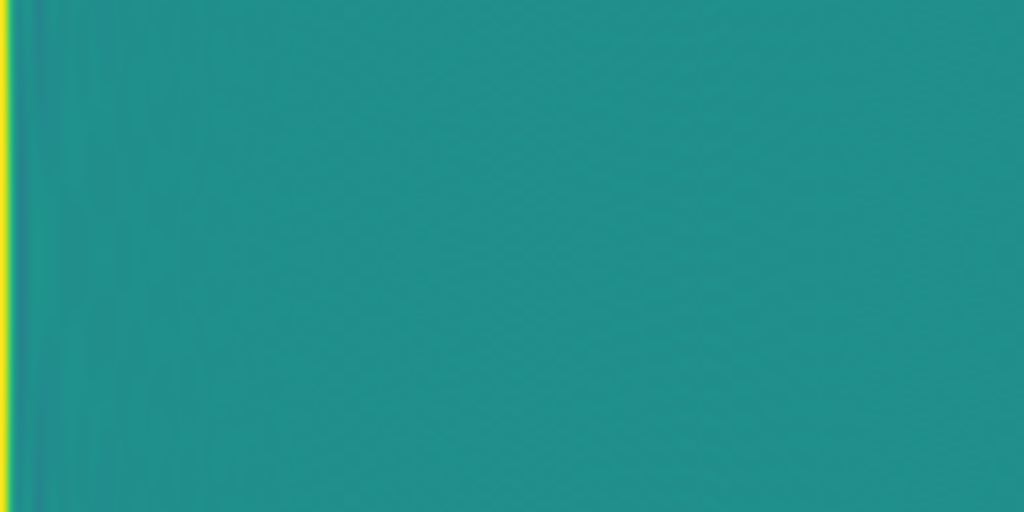

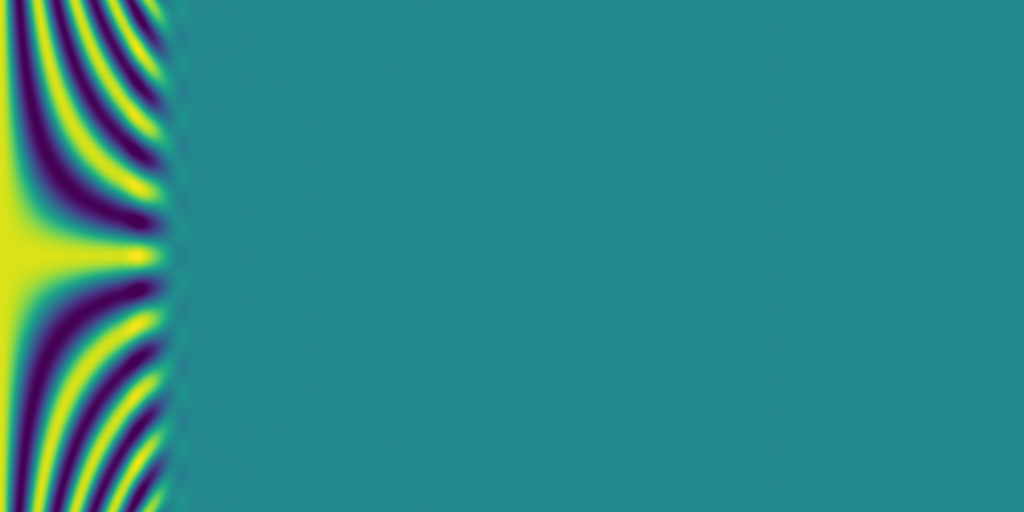

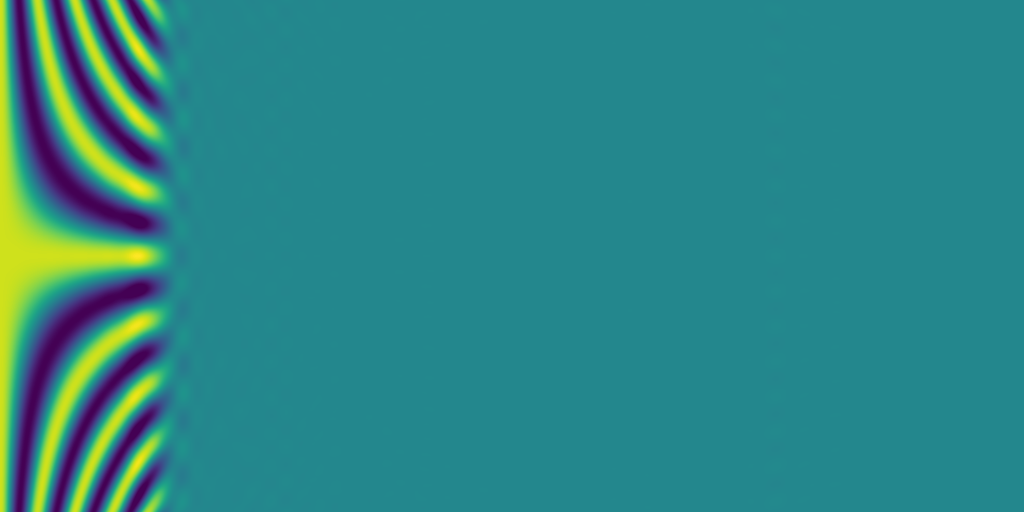

In [10]:
z_f = 20.0
img_tsr = compute_imaging_tensor(x_r[..., np.newaxis, np.newaxis], ivl_a, ivl_b, z_r, z_a, z_b, z_f, pupil_diameter)

display_image(single_test(img_tsr, z_f, 1.0))
display_image(single_test(img_tsr, z_f, unsinc_filter))
display_image(single_test(img_tsr, z_f, box_filter))
display_image(single_test(img_tsr, z_f, unsinc_box_filter))
display_image(single_test(img_tsr, z_f, thin_hourglass_filter))
display_image(single_test(img_tsr, z_f, unsinc_thin_hourglass_filter))
display_image(single_test(img_tsr, z_f, thick_hourglass_filter))
display_image(single_test(img_tsr, z_f, unsinc_thick_hourglass_filter))

In [11]:
def full_test(filter_kernel):
    result = np.zeros((1024, 1024))
    for idx, z_f in enumerate(tqdm(np.linspace(1.0, 1000.0, 1024))):
        img_tsr = compute_imaging_tensor(x_r[..., np.newaxis, np.newaxis], ivl_a, ivl_b, z_r, z_a, z_b, z_f, pupil_diameter)
        result_f = single_test(img_tsr, z_f, filter_kernel)
        error = result_f/np.amax(result_f) - ground_truth
        result[:, idx] = np.sum(np.square(error), axis=1)
    return result

In [12]:
plain_result = full_test(1.0)
unsinc_result = full_test(unsinc_filter)
box_result = full_test(box_filter)
unsinc_box_result = full_test(unsinc_box_filter)
thin_hourglass_result = full_test(thin_hourglass_filter)
unsinc_thin_hourglass_result = full_test(unsinc_thin_hourglass_filter)
thick_hourglass_result = full_test(thick_hourglass_filter)
unsinc_thick_hourglass_result = full_test(unsinc_thick_hourglass_filter)

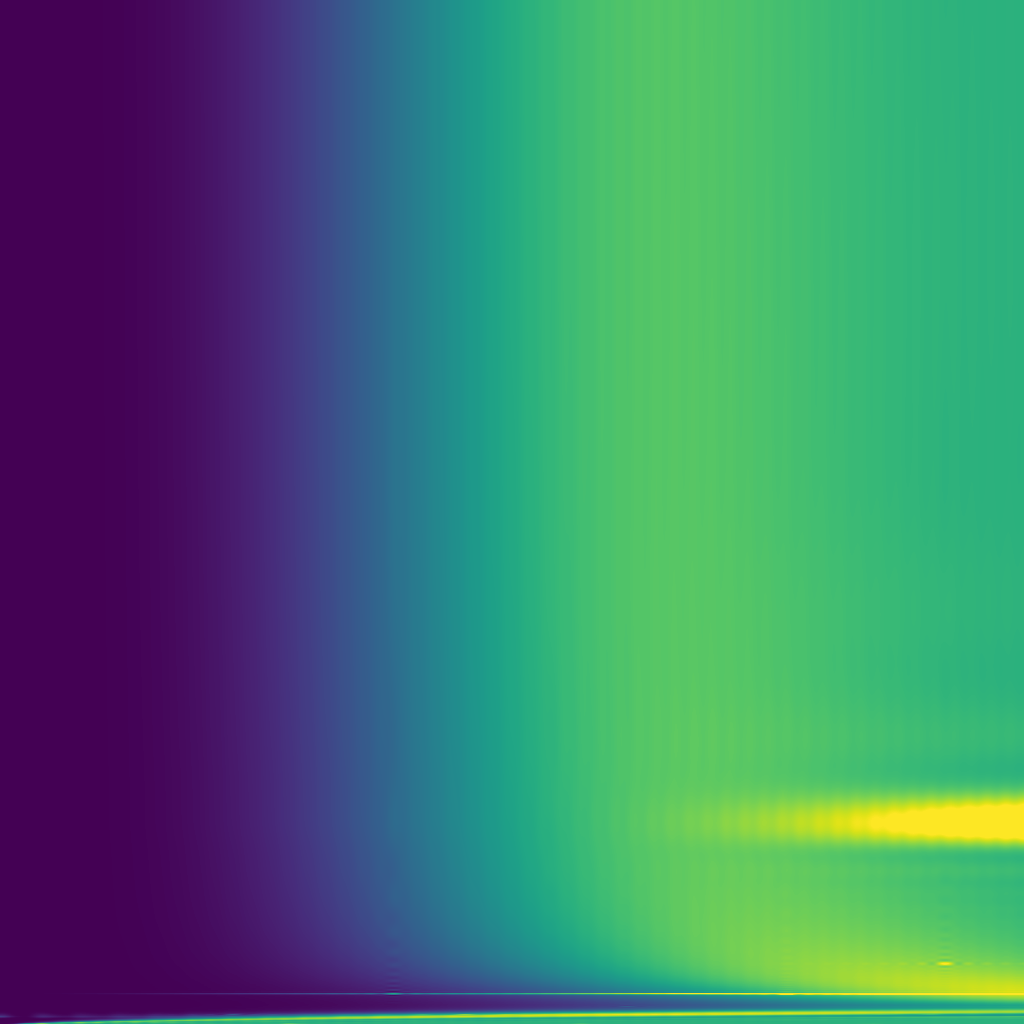

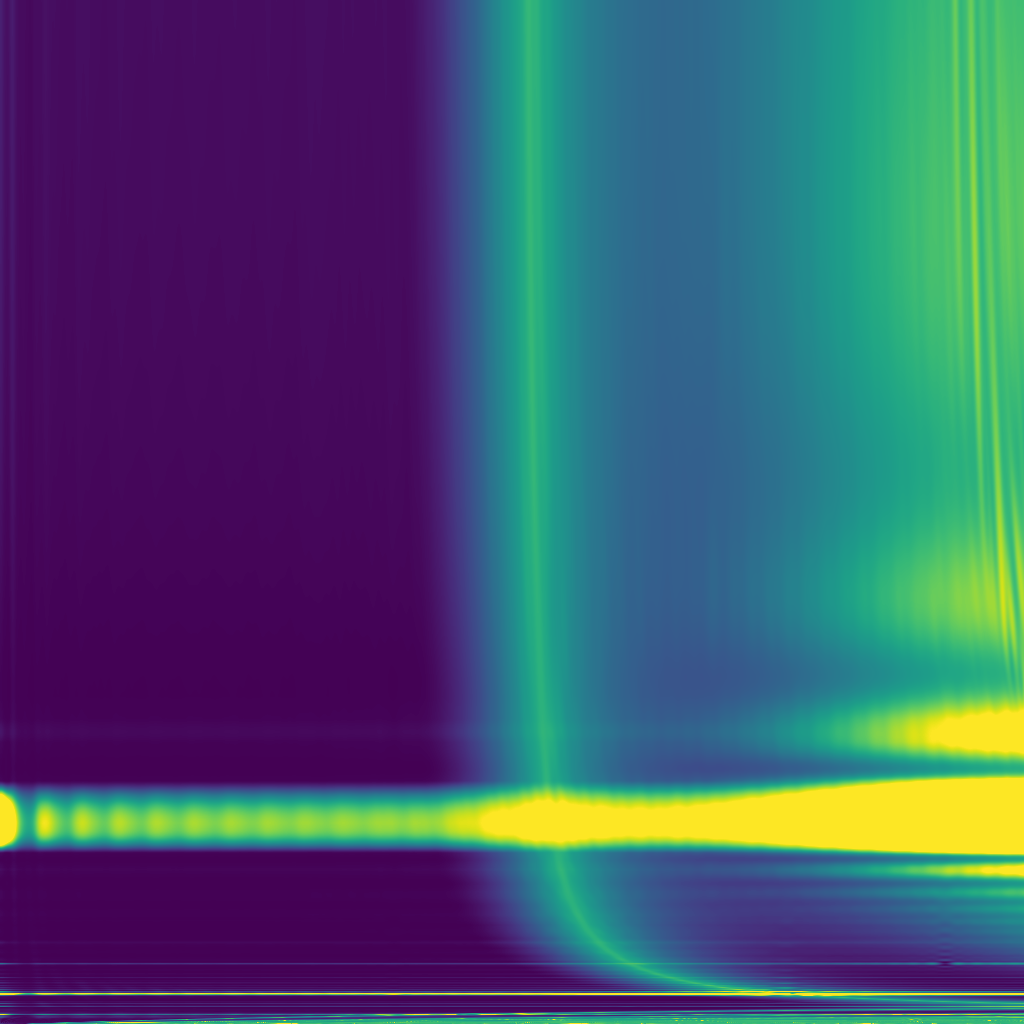

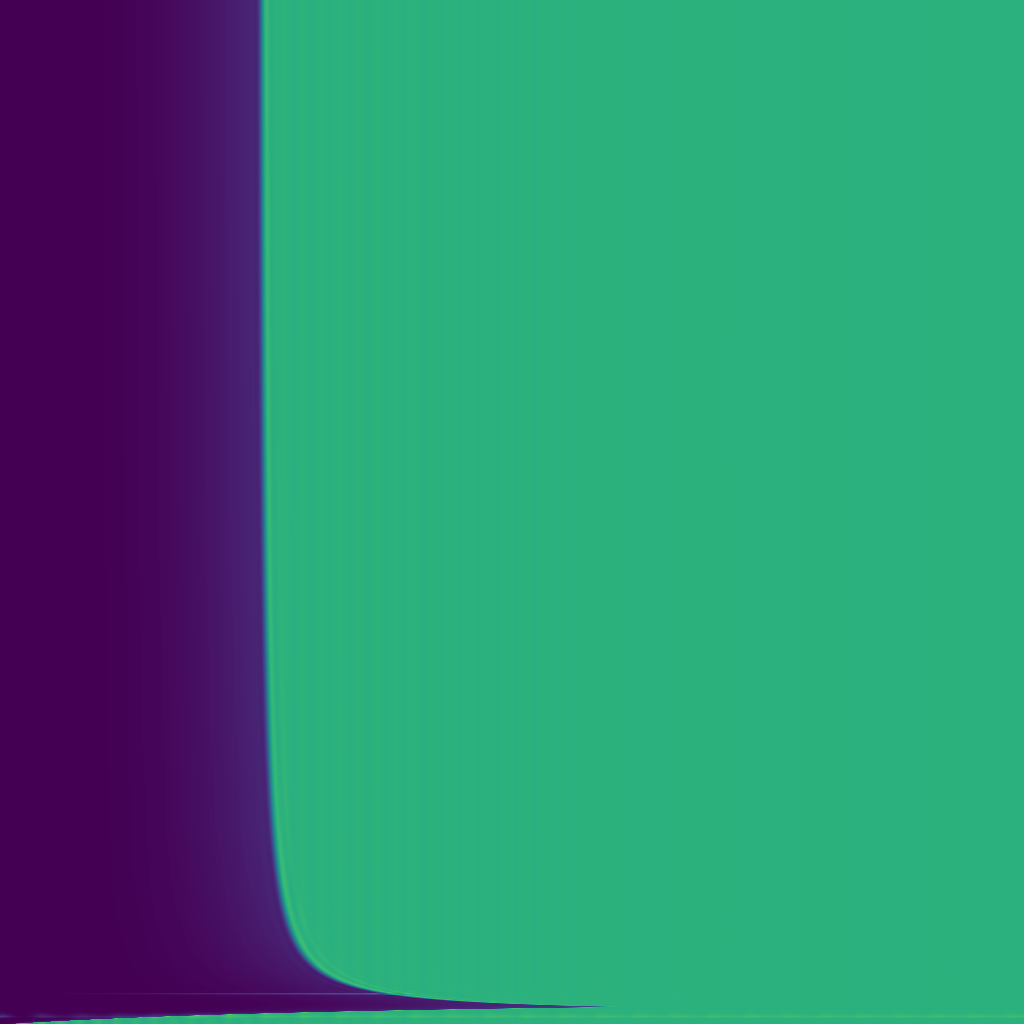

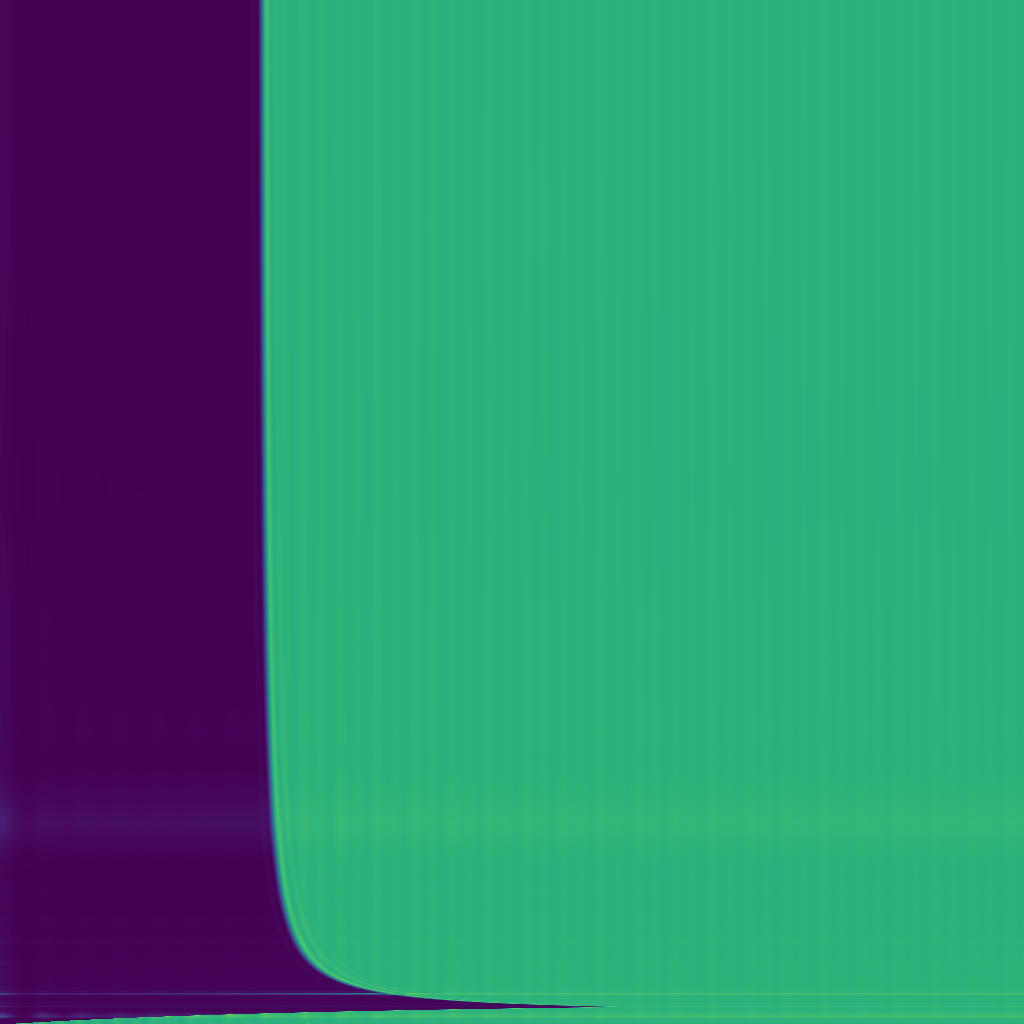

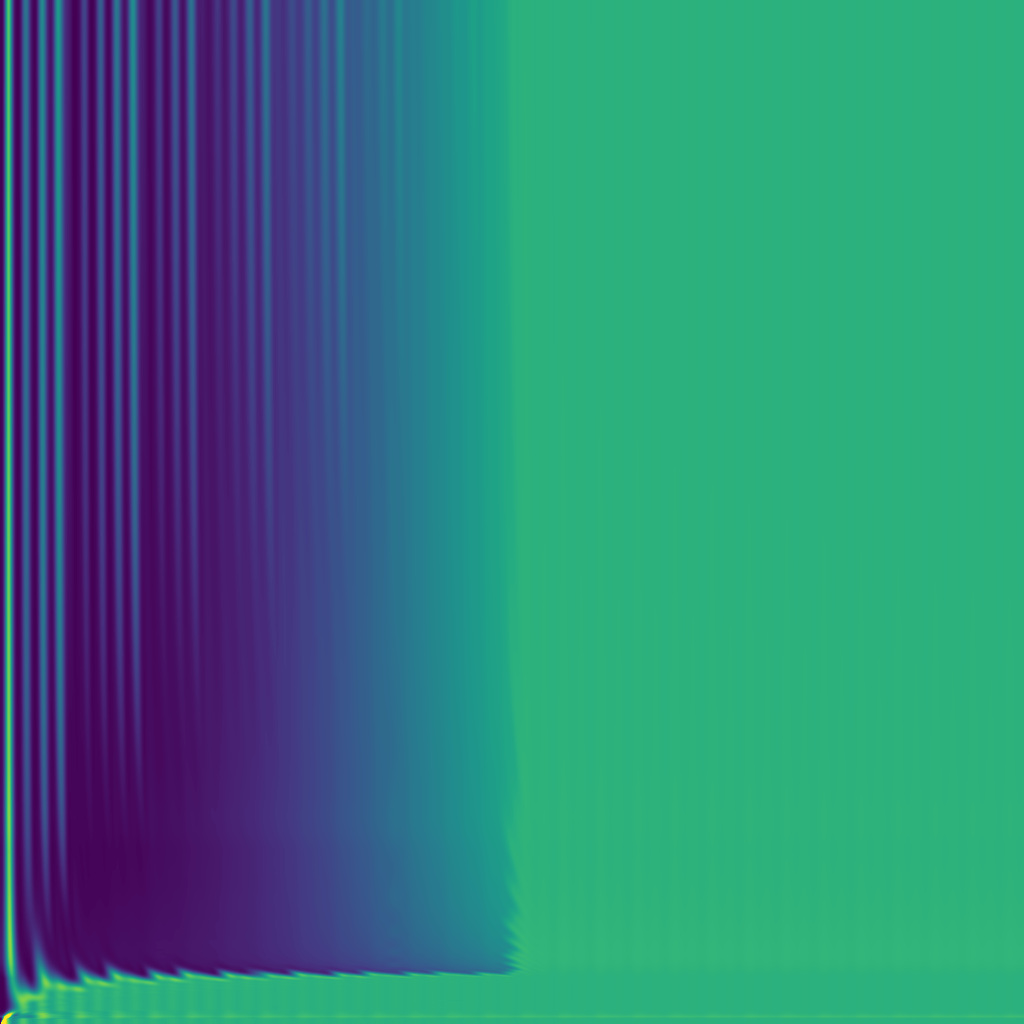

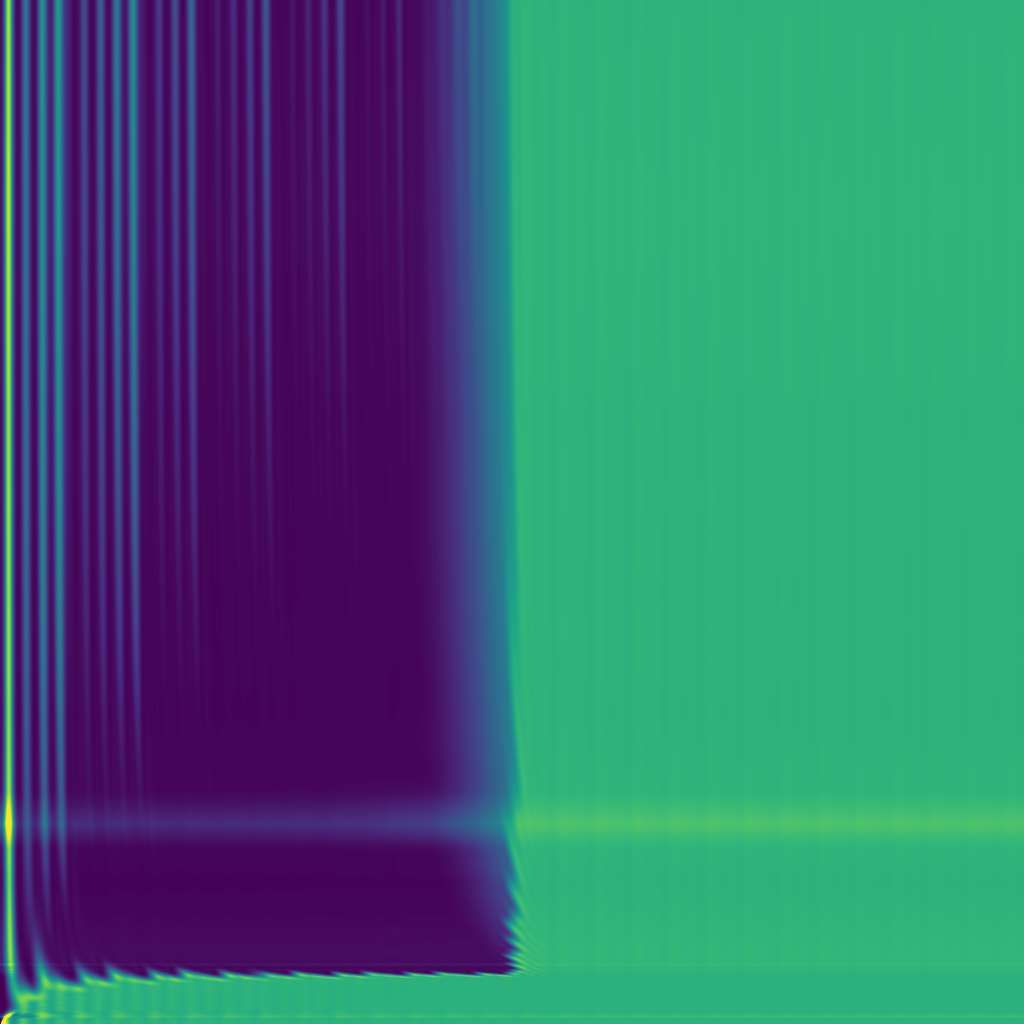

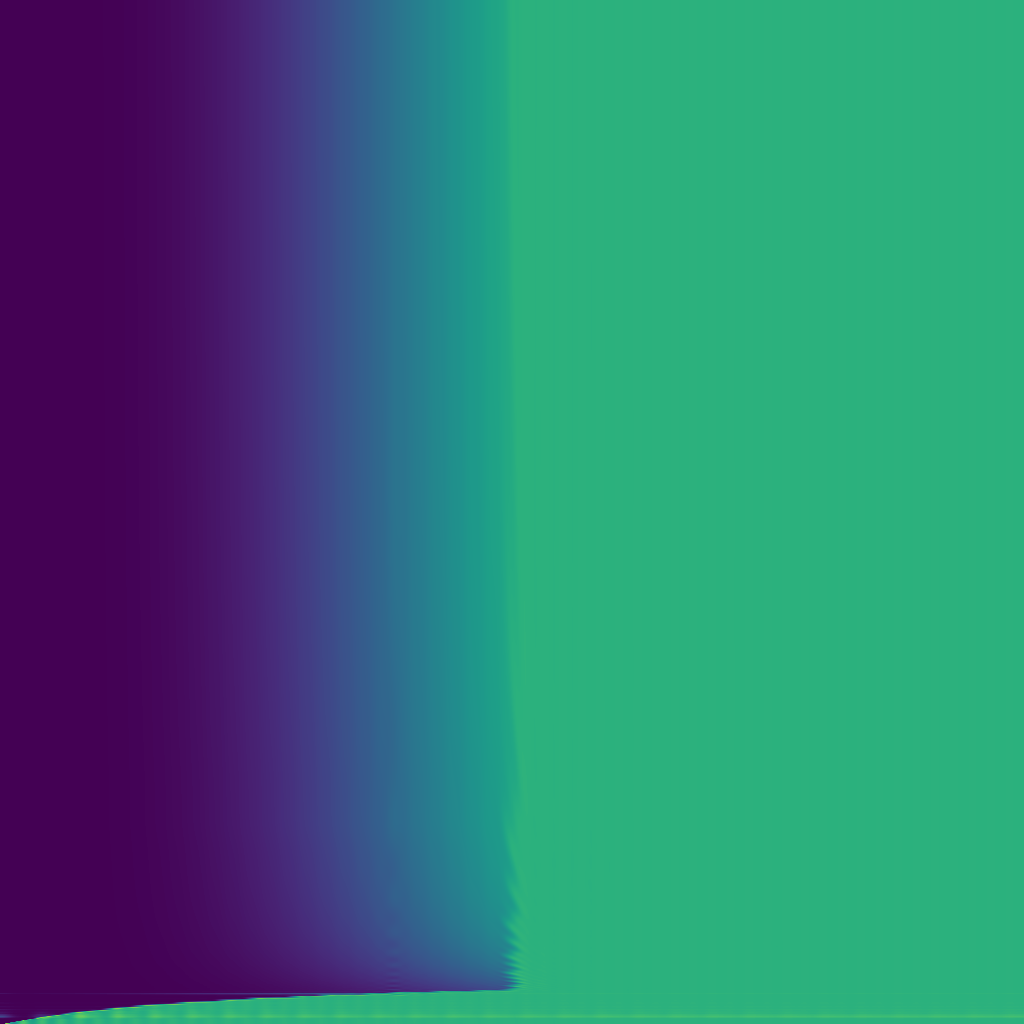

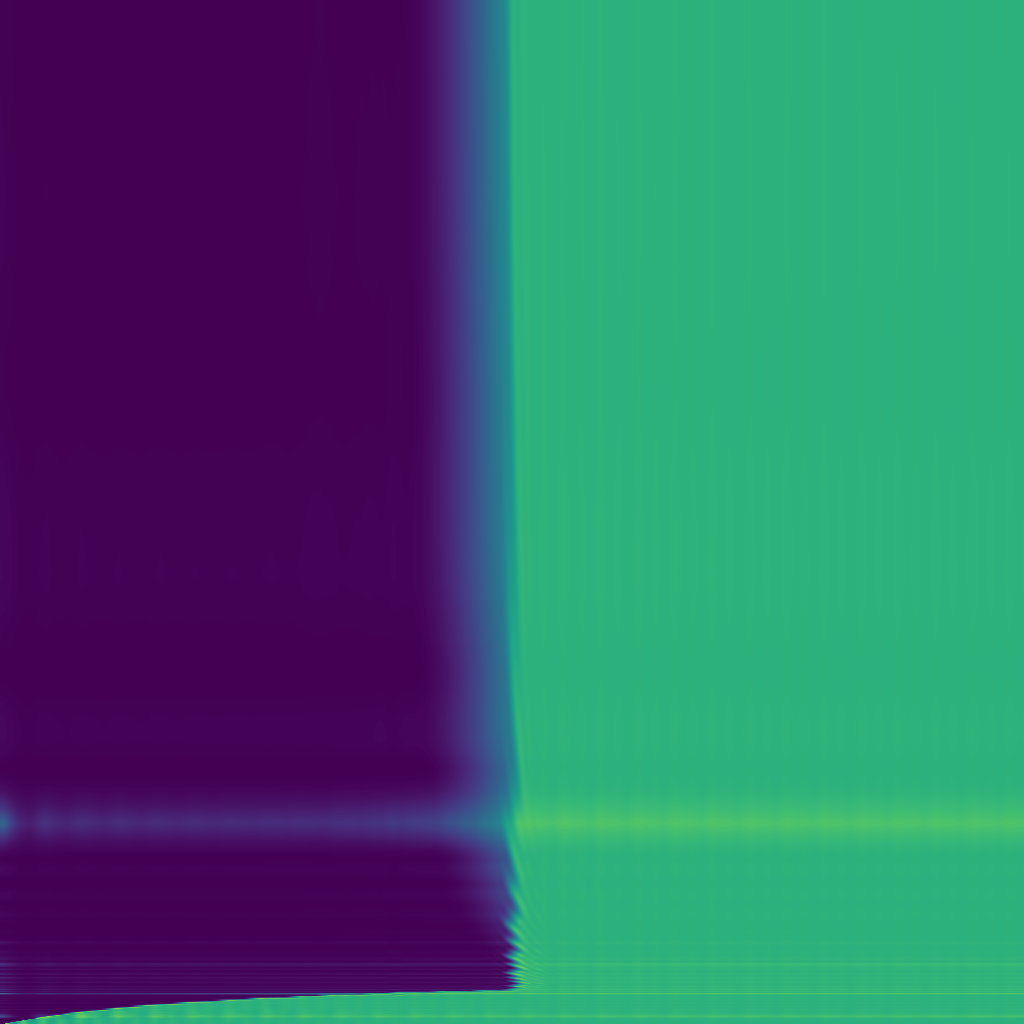

In [20]:
maximum = max(np.amax(plain_result), np.amax(unsinc_result),
              np.amax(box_result), np.amax(unsinc_box_result),
              np.amax(thin_hourglass_result), np.amax(unsinc_thin_hourglass_result),
              np.amax(thick_hourglass_result), np.amax(unsinc_thick_hourglass_result))
maximum = 100

display_image(plain_result/maximum)
display_image(unsinc_result/maximum)
display_image(box_result/maximum)
display_image(unsinc_box_result/maximum)
display_image(thin_hourglass_result/maximum)
display_image(unsinc_thin_hourglass_result/maximum)
display_image(thick_hourglass_result/maximum)
display_image(unsinc_thick_hourglass_result/maximum)